# YOLO Boat Detection: Training Notebook

This notebook demonstrates how to train a YOLO model to detect boats in open water using a preprocessed dataset (auto-orient, resize 640x640, random noise, and rotations) located in `/dataset`.

**Outline:**
1. Import Required Libraries
2. Load and Inspect the Dataset
3. Prepare YOLO-Compatible Dataset Structure
4. Configure YOLO Model and Training Parameters
5. Train the YOLO Model
6. Visualize Training Metrics
7. Evaluate Model Performance on Validation Data
8. Run Inference on Sample Images

In [1]:
# 1. Import Required Libraries
import os
import random
import torch
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO

## 2. Load and Inspect the Dataset

Let's visualize a few random images and their labels to verify preprocessing and augmentation. 

**Dataset details:**
- Exported from Roboflow (Jan 30, 2026)
- 116 images, YOLOv11 format
- Preprocessing: auto-orientation, resize to 640x640 (stretch)
- Augmentation: random rotation (-10° to +10°), salt & pepper noise (0.14% pixels), 3 versions per image
- Already split into train, valid, and test sets

For more info and state-of-the-art notebooks, see: https://github.com/roboflow/notebooks

Image: IM_00275_JPG.rf.3a77cd100d6c2187a0b6ea70e28890c4.jpg


Image: IM_00275_JPG.rf.3a77cd100d6c2187a0b6ea70e28890c4.jpg


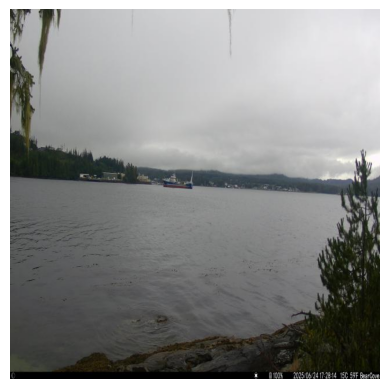

Image: IM_00275_JPG.rf.3a77cd100d6c2187a0b6ea70e28890c4.jpg


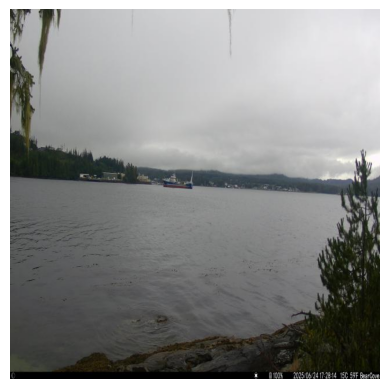

Image: IM_00086_JPG.rf.007537839d6772e66f027734dc876bbb.jpg


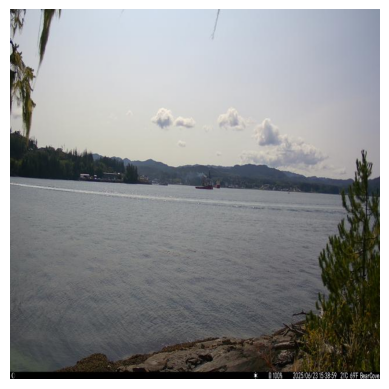

Image: IM_00275_JPG.rf.3a77cd100d6c2187a0b6ea70e28890c4.jpg


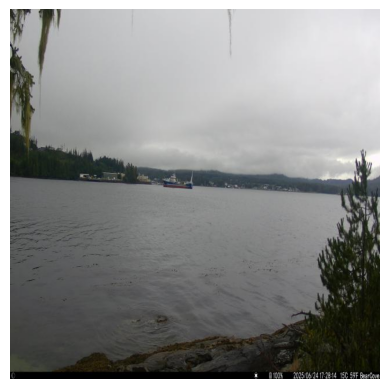

Image: IM_00086_JPG.rf.007537839d6772e66f027734dc876bbb.jpg


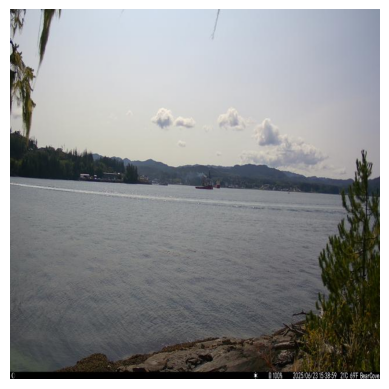

Image: IM_00425_JPG.rf.fbd32103839d3dcf5199e5e242e9e03d.jpg


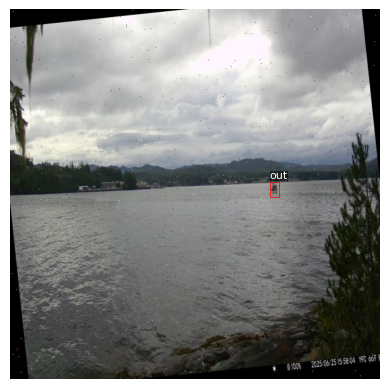

In [2]:
# Visualize random images and their YOLO labels, with class name (in/out)
def plot_yolo_labels(img_path, label_path):
    class_names = ['in', 'out'] 
    img = Image.open(img_path)
    w, h = img.size
    boxes = []
    labels = []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                cls, x, y, bw, bh = map(float, line.strip().split())
                # Convert YOLO format to box coordinates
                x1 = (x - bw/2) * w
                y1 = (y - bh/2) * h
                x2 = (x + bw/2) * w
                y2 = (y + bh/2) * h
                boxes.append((x1, y1, x2, y2))
                labels.append(int(cls))
    plt.imshow(img)
    ax = plt.gca()
    for box, cls in zip(boxes, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False, color='red', linewidth=0.5)
        ax.add_patch(rect)
        # Add class name label above the box
        ax.text(box[0], box[1] - 2, class_names[cls], color='white', fontsize=8, va='bottom', ha='left', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', pad=0))
    plt.axis('off')
    plt.show()


    
img_dir = "img\\chokepoint v1\\train\\images"
label_dir = "img\\chokepoint v1\\train\\labels"
img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))]
for i in range(3):
    img_file = random.choice(img_files)
    label_file = os.path.splitext(img_file)[0] + '.txt'
    print(f"Image: {img_file}")
    plot_yolo_labels(os.path.join(img_dir, img_file), os.path.join(label_dir, label_file))

## 3. Prepare YOLO-Compatible Dataset Structure

Ensure the dataset is in YOLO format:
- `/dataset/images/train`, `/dataset/images/val`, `/dataset/images/test`
- `/dataset/labels/train`, `/dataset/labels/val`, `/dataset/labels/test`

If not, split and organize the dataset accordingly.

In [3]:
# Printing number of images in train/test/valid splits - sanity check
splits = ['train', 'valid', 'test']
for split in splits:
    img_dir = os.path.join('img', 'chokepoint v1', split, 'images')
    label_dir = os.path.join('img', 'chokepoint v1', split, 'labels')
    num_imgs = len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png'))])
    num_labels = len([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    print(f"{split.capitalize()} - Images: {num_imgs}, Labels: {num_labels}")

Train - Images: 99, Labels: 99
Valid - Images: 12, Labels: 12
Test - Images: 5, Labels: 5


## 4. Configure YOLO Model and Training Parameters

Set up the YOLO model, number of classes, and training configuration.

In [4]:
# Define YOLO config YAML for custom dataset
yolo_yaml = '''
path: ./img/chokepoint v1
train: train/images
val: valid/images
nc: 2
names: ['in','out']
'''
with open('boat_data.yaml', 'w') as f:
    f.write(yolo_yaml)

# Choose YOLO model - v8n is small/fast, v8m/v8l for more accuracy
model = YOLO('yolov8n.pt')  

## 5. Train the YOLO Model

Train the model using the custom dataset and configuration.

In [5]:
# Train the YOLO model with more epochs and early stopping
results = model.train(
    data='boat_data.yaml',
    epochs=100,  # Increase epochs for better accuracy
    imgsz=640,
    batch=16,
    project='yolo_boat_runs',
    name='exp',
    exist_ok=True,
    patience=10  # Early stopping if no improvement for 10 epochs
    )

New https://pypi.org/project/ultralytics/8.4.10 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=boat_data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=exp, nbs=64, nms=False, opse

## 6. Visualize Training Metrics

Plot training and validation loss, mAP, and other metrics to monitor model performance.

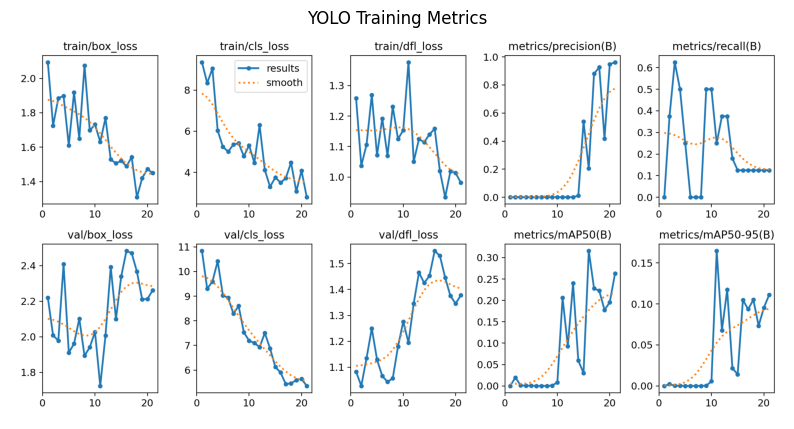

In [6]:
# Plot training results (loss, mAP, etc.)
results_path = 'runs\\detect\\yolo_boat_runs\\exp\\results.png'
if os.path.exists(results_path):
    img = Image.open(results_path)
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis('off')
    plt.title('YOLO Training Metrics')
    plt.show()
else:
    print('Training results plot not found.')

## 7. Evaluate Model Performance on Validation Data

Evaluate the trained model on the validation set and display metrics and example predictions.

In [ ]:
# Evaluate on validation set 
metrics = model.val(data='boat_data.yaml', split='val', name='val', exist_ok=True)  
print(metrics)

Ultralytics 8.4.9  Python-3.11.14 torch-2.10.0+cpu CPU (Intel Core i7-6600U 2.60GHz)
val: Fast image access  (ping: 0.30.2 ms, read: 78.852.4 MB/s, size: 42.6 KB)
val: Scanning C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\valid\labels.cache... 12 images, 7 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 12/12  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 4.5s/it 4.5s
                   all         12          6   0.000494       0.25      0.206      0.165
                    in          4          4   0.000987        0.5      0.412       0.33
                   out          1          2          0          0          0          0
Speed: 3.1ms preprocess, 306.4ms inference, 0.0ms loss, 43.1ms postprocess per image
Results saved to C:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\runs\detect\val
Precision: None
Recall: None
Accuracy (mAP@0.5): None
ultralytics.utils.metrics.DetMetrics obj

In [8]:

# Show predictions on a few validation images
val_img_dir = 'img\\chokepoint v1\\valid\\images'
val_imgs = [os.path.join(val_img_dir, f) for f in os.listdir(val_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(val_imgs, min(3, len(val_imgs))):
    results = model(img_path)
    results[0].show()


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\valid\images\IM_00705_JPG.rf.66554a0cda74feb1972a30e4ba59d226.jpg: 640x640 (no detections), 407.6ms
Speed: 190.0ms preprocess, 407.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\valid\images\IM_00707_JPG.rf.fa40328379d479112977f885a9b7d961.jpg: 640x640 (no detections), 585.0ms
Speed: 8.6ms preprocess, 585.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\valid\images\IM_00050_JPG.rf.2e762d7d3b724cc23c84ad88b4fadcb3.jpg: 640x640 (no detections), 748.0ms
Speed: 10.5ms preprocess, 748.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


## 8. Run Inference on Sample Images

Use the trained model to predict boats in new images and visualize the results.

In [9]:
# Inference on new images (replace with your test images)
test_img_dir='img\\chokepoint v1\\test\\images'  # or any folder with new images
test_imgs = [os.path.join(test_img_dir, f) for f in os.listdir(test_img_dir) if f.endswith(('.jpg', '.png'))]
for img_path in random.sample(test_imgs, min(3, len(test_imgs))):
    results = model(img_path)
    results[0].show()


image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00817_JPG.rf.aa396d6103027093088dc880c7faa5fc.jpg: 640x640 (no detections), 5295.9ms
Speed: 47.8ms preprocess, 5295.9ms inference, 19.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00051_JPG.rf.4af689e62e60e7f143046ac6cad3a556.jpg: 640x640 (no detections), 8260.9ms
Speed: 63.4ms preprocess, 8260.9ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 c:\Users\hp\Desktop\PSF\camera_fishing_effort\notebooks\img\chokepoint v1\test\images\IM_00084_JPG.rf.0fc201626f06df43d3cff3db4f99a80b.jpg: 640x640 (no detections), 3261.6ms
Speed: 112.4ms preprocess, 3261.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
